# Autogluon TImeSeries 실습

간단한 fit() 호출을 통해 Autogluon은 훈련하고 조정할 수 있음
* 단순 예측 모델 (예 : ARIMA, ETS, Theta)
* 강력한 딥러닝 모델(예 : DeepAR, Temporal Fusion Transformer),
* 트리 기반 모델 (예 : LightGBM),
* 다른 트리 모델의 예측을 결합한 앙상블

## Autogluon을 사용하여 M4 예측 경쟁 데이터 세트에 대한 시간별 예측 생성할 것

In [1]:
# 데이터 로드

import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

* TimeSeriesDataFrame : 여러 시계열로 구성된 데이터 세트를 저장

* TimeSeriesPredictor : 최적의 예측 모델을 피팅, 조정 및 선택하고 새로운 예측을 생성 담당

In [2]:
#M4 시간별 데이터세트의 하위 집합 로드

df = pd.read_csv("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/train.csv")
df.head()

,item_id,timestamp,target
0,H1,1750-01-01 00:00:00,605.0
1,H1,1750-01-01 01:00:00,586.0
2,H1,1750-01-01 02:00:00,586.0
3,H1,1750-01-01 03:00:00,559.0
4,H1,1750-01-01 04:00:00,511.0


데이터 프레임의 각 행에는 다음으로 표시되는 단일 시계열의 단일 관찰(시간 단계)이 포함됨
* 시계열의 고유 ID("item_id")(int 또는 str)
* 관찰의 타임스탬프("timestamp") pandas.Timestamp 또는 호환 가능한 형식
* 시계열의 숫자 값("target")

원시 데이터는 위의 3개 이상의 열이 있는 형식을 따라야 하지만, 열의 이름은 임의적이어도 됨
하지만 모델을 구성할 때 열 이름을 제공하는 것이 중요함.
Autogluon은 데이터가 예상 형식과 일치하지 않으면 예외를 발생시킴




In [4]:
train = TimeSeriesDataFrame.from_data_frame(
    df, 
    id_column="item_id",
    timestamp_column="timestamp")

train.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

TimeSeriesDataFrame은 item에 저장된 각 개별 시계열을 참조함. 항목은 수요 예측의 다양한 제품에 해당하거나 금융 데이터 세트의 다양한 주식에 해당할 수 있음.
이 설정을 시계열 패널이라고 함. 
Autogluon은 서로 다른 항목(시계열)간의 상호 작용을 모델링하지 않고 각 시계열에 대한 예측을 개별적으로 생성함


In [6]:
#학습
#시계열의 미래 값을 예측하려면 TimeSeriesPredictor객체를 생성해야 함
#작업에 따라 단계 수 (예측 범위)를 선택함.
#예를 들어 시간별 빈도로 측정된 시계열은 최대 48시간까지 미래를 예측한다던가 하는 방법
# ex) prediction_length = 48

#./autogluon-m4-hourly 폴더에 있는 훈련된 모델 사용

predictor = TimeSeriesPredictor(
    prediction_length=48,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="MASE",
)

predictor.fit(
    train,
    presets="medium_quality",
    time_limit=600,
)

#fast_training, high_quality, best_quality 을 가지고 있는데 더 높은 품질일수록 정확도는 높지만 시간이 오래걸림
# fit()AutoGluon은 주어진 시간 내에 가능한 한 많은 모델을 훈련시키고 성능 기준으로 순위 매김


================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: medium_quality
Fitting with arguments:
{'enable_ensemble': True,
 'evaluation_metric': 'MASE',
 'excluded_model_types': None,
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'medium_quality',
 'num_val_windows': 1,
 'prediction_length': 48,
 'random_seed': None,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}
Provided training data set with 148060 rows, 200 items (item = single time series). Average time series length is 740.3. Data frequency is 'H'.
AutoGluon will save models to autogluon-m4-hourly\
AutoGluon will gauge predictive performance using evaluation metric: 'MASE'
	This metric's sign has been flipped to adhere to being 'higher is better'. The reported score can be multiplied by -1 to get the metric value.

Provided dataset contains following columns:
	target:           'target'

Starting training. Start time is 2023-11-28 18:02:23
Models that will be 

In [7]:
#예측 생성 (미래 시계열 값 예측)
predictions = predictor.predict(train)
predictions.head()


#Autogluon은 확률적 예측 생성
#미래 시계열의 평균(예상 값)을 예측하는 것외에도 예측 분포의 분위수도 제공함


Global seed set to 123
Model not specified in predict, will default to the model with the best validation score: RecursiveTabular


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  621.022377  591.515051  601.644310  608.948218   
        1750-01-30 05:00:00  555.173747  513.444087  527.769022  538.098308   
        1750-01-30 06:00:00  512.971912  461.863725  479.408116  492.058856   
        1750-01-30 07:00:00  478.888969  419.874318  440.132836  454.740653   
        1750-01-30 08:00:00  456.222546  390.242160  412.891872  429.223907   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
H1      1750-01-30 04:00:00  615.189139  621.022377  626.855615  633.096535   
        1750-01-30 05:00:00  546.924302  555.173747  563.423191  572.249185   
        1750-01-30 06:00:00  502.868447  512.971912  523.075377  533.884968   
        1750-01-30 07:00:00  467.222493  478.888969  490.555446  503.037286   
        1750-01-30 08:00:00  443.179029  456.222546  469.266063  483.221185   

                                    0.8         0.9  
item_id timestamp                                    
H1      1750-01-30 04:00:00  640.400443  650.529702  
        1750-01-30 05:00:00  582.578471  596.903406  
        1750-01-30 06:00:00  546.535708  564.080099  
        1750-01-30 07:00:00  517.645103  537.903620  
        1750-01-30 08:00:00  499.553220  522.202931

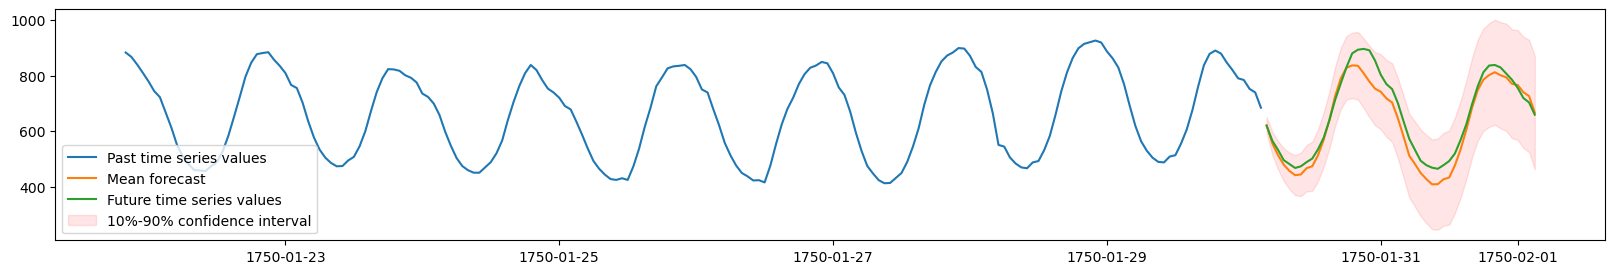

In [8]:
#예측과 실제로 관찰된 값을 시각화 하기

import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
test = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

item_id = "H1"
y_past = train.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test.loc[item_id]["target"][-48:]

plt.plot(y_past[-200:], label="Past time series values") #과거 시계열 값
plt.plot(y_pred["mean"], label="Mean forecast") #예측 값
plt.plot(y_test, label="Future time series values") #미래 시계열 값

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();



In [9]:
#각 모델의 성능평가 
predictor.leaderboard(test, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,RecursiveTabular,-0.870271,-0.898770,2.066654,2.806082,15.765456,5
1,SeasonalNaive,-1.022854,-1.216909,0.277788,0.244996,0.130301,2
2,AutoETS,-1.778531,-1.939939,138.593510,114.842881,0.122606,4
3,Theta,-1.905365,-2.142531,18.150196,30.333692,0.134324,3
4,DeepAR,-2.968443,-2.515405,18.820922,17.778352,424.545723,6
5,Naive,-6.696079,-6.662942,17.781558,10.624432,0.129802,1
